# Introduction to Data Analytics Coursework -- Text Analytics Data Loader

For this coursework, we recommend that you use your virtual environment that you created for the labs. Alternatively, create a fresh environment following the instructions in the [README.md in the intro-labs-public Github repository](https://github.com/uob-TextAnalytics/intro-labs-public). 

In [1]:
%load_ext autoreload
%autoreload 2

# Use HuggingFace's datasets library to access the financial_phrasebank dataset
from datasets import load_dataset

import numpy as np

C:\Users\Morg\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Financial Question Answering Task 1 -- Sentiment Analysis (FiQA SA)

The FiQA SA dataset contains two sets of different instances: news headlines and social media posts. The data is available from the website of the FiQA competition: https://sites.google.com/view/fiqa/home . 

Each instance has a continuous sentiment score. Our task is to classify the posts into positive (2), negative (0) or neutral (1). First, load both the headlines and posts, along with their sentiment scores, then bin the scores into positive, negative and neutral:

In [2]:
train_files = [
    'data_cache/FiQA_ABSA_task1/task1_headline_ABSA_train.json',
    'data_cache/FiQA_ABSA_task1/task1_post_ABSA_train.json'
]

In [3]:
import json

def load_fiqa_sa_from_json(json_files):
    train_text = []
    train_labels = []

    for file in json_files:
        with open(file, 'r', encoding="utf8") as handle:
            dataf = json.load(handle)

        dataf_text = [dataf[k]["sentence"] for k in dataf.keys()]
        # print(len(dataf_text))
        train_text.extend(dataf_text)

        dataf_labels = [float(dataf[k]["info"][0]["sentiment_score"]) for k in dataf.keys()]
        # print(len(dataf_labels))
        train_labels.extend(dataf_labels)

    train_text = np.array(train_text)
    train_labels = np.array(train_labels)
    
    return train_text, train_labels


def threshold_scores(scores):
    """
    Convert sentiment scores to discrete labels.
    0 = negative.
    1 = neutral.
    2 = positive.
    """
    labels = []
    for score in scores:
        if score < -0.2:
            labels.append(0)
        elif score > 0.2:
            labels.append(2)
        else:
            labels.append(1)
            
    return np.array(labels)


all_text, all_labels = load_fiqa_sa_from_json(train_files)
    
print(f'Number of instances: {len(all_text)}')
print(f'Number of labels: {len(all_labels)}')

all_labels = threshold_scores(all_labels)
print(f'Number of negative labels: {np.sum(all_labels==0)}')
print(f'Number of neutral labels: {np.sum(all_labels==1)}')
print(f'Number of positive labels: {np.sum(all_labels==2)}')

Number of instances: 1111
Number of labels: 1111
Number of negative labels: 310
Number of neutral labels: 195
Number of positive labels: 606


Let's create a test split, which we can hold out until we have tuned our method(s).

We may also need a _validation_ set (also called 'development' set or 'devset'), which can be used to compute performance of your model when tuning hyperparameters,  optimising combinations of features, or looking at the errors your model makes before improving it. This allows you to hold out the test set (i.e., not to look at it at all when developing your method) to give a fair evaluation of the model and how well it generalises to new examples. This avoids tuning the model to specific examples in the test set. An alternative approach to validation set does not use a single fixed validation set, but instead uses [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html). 

# Task 1

## Sentiment Analysis

### Pre-processing

In [4]:
from sklearn.model_selection import train_test_split

# Split test data from training data
train_documents, test_documents, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels # make sure the same proportion of labels is in the test set and training set
)

In [5]:
import re

all_matches = []

for text in all_text:
    matches = re.findall(r'[+][0-9.]*[0-9]+%', text)
    if len(matches) == 0:
        continue
    else:
        all_matches.extend(matches)
print(len(all_matches)) 
for match in set(all_matches):  # Use a set to get a list of the unique matches
    print(match) 

17
+4.1%
+550%
+13.26%
+3.4%
+36%
+1.46%
+7.0%
+7.8%
+1%
+5%
+20.84%
+4.6%
+35%
+4.2%
+3%


In [6]:
import re
import nltk
from gensim.parsing.preprocessing import STOPWORDS

punctuations = ['(',')','-','[',']','{','}',';',':',',','.','/','?','@','#','$','%','^','&','*','_','~','!','..','...']
punctuations2 = ['(',')','-','[',']','{','}',';',':',',','.','/','?','@','#','$','%','^','&','*','_','~']

def get_unique_values(x):
    array = np.array(x)
    return np.unique(array).tolist()

lemmatizer = nltk.WordNetLemmatizer()

class Preprocessor(object):
    def __call__(self, headline):
        
        headline = re.sub(r'https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&\/=]*)', r'URL', headline) # REPLACING URLs with 'URL'
        headline = re.sub(r'\$[a-zA-Z.]*[a-zA-Z]+', r'TICKER', headline) # replace ticker symbols with 'TICKER'
        headline = re.sub(r'#[a-zA-Z1-9]*', 'HASHTAG', headline) # replace ticker symbols with 'TICKER'
        headline = re.sub(r'[+][0-9.]*[0-9]+%', 'POSPCT', headline)
        headline = re.sub(r'[-][0-9.]*[0-9]+%', 'NEGPCT', headline)
        headline = re.sub(r'[0-9.]*[0-9]+%', 'NOSIGNPCT', headline)
        
        return headline
        
class Tokenizer(object):
    def __call__(self, text):
        
        result = []
        negation = False
        for token in nltk.word_tokenize(text) :  # Tokenize
            if token in STOPWORDS:
                continue
            token = lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(token, pos='a'), pos='v'), pos='n') # Lemmatize
            if token.lower() in ["n't", 'not', 'no', 'never']: # Negation handling
                negation = True
            elif negation == True and token in punctuations:
                negation = False
            elif negation == True:
                token = '_NOT' + token
            else:
                pass
            if token in punctuations2:
                pass
            else:
                result.append(token.lower()) # Make all lower case
        return get_unique_values(result) # Makes it BINARY Multinomial NB

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

tokenizer = Tokenizer()
preprocessor = Preprocessor()

vectorizer_train = CountVectorizer(tokenizer=Tokenizer(), preprocessor=Preprocessor())
vectorizer_train.fit(train_documents)
vocab = vectorizer_train.vocabulary_.keys()

vectorizer_test = CountVectorizer(tokenizer=Tokenizer(), preprocessor=Preprocessor())
vectorizer_test.fit(test_documents)
vocab_test = vectorizer_test.vocabulary_.keys()

count = 0

for word in vocab_test:
    if word not in vocab:
        count += 1
            
print(f'Number of words in the train vocabulary: {len(vocab)}\nNumber of words in the test vocabulary: {len(vocab_test)}\nNumber of words in test vocabulary that are not in the training vocabulary: {count}')

C:\Users\Morg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Number of words in the train vocabulary: 2778
Number of words in the test vocabulary: 1032
Number of words in test vocabulary that are not in the training vocabulary: 400


In [8]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
analyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Morg\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
for i in range(100):
    print(train_documents[i])

Are Aviva plc, Direct Line Insurance Group PLC And Admiral Group plc Set To Soar?
$NFLX Easy pop to 500$ by end of feb.. Then steady as she goes for 600 into second earnings report..800$ year end no matter what
Commented on It's Time To Embrace Dividend Growth https://t.co/wc2qfP79TN $ABBV $CSCO $WYN
@catskillfishing  Note the monthly chart of $GDX & how it recaptured support. $GLD possible double bottom set up. http://stks.co/aw6z
Reed Elsevier share price slides on underwhelming full-year results
Barclays PLC & Lloyds Banking Group PLC Are The 2 Banks I'd Buy Today
$aapl short term fund/redemption liquidations.. Should have the channel cleared soon and on solid footing. $520 is new floor come July! :)
@louiebeene vwap is 1.63, held the trend line. Should be on a LOT of radars. $NAVB
volatility squeeze in $AAPL. I hope it gets resolved to the upside
Aviva shuts Friends Life head office in rapid integration move
$SIGA Bid for Reargument Denied by Judge
$BONE Earnings Stocks Poised to P

In [10]:
tokenizer = Tokenizer()
preprocessor = Preprocessor()

for i in range(100):
    print(tokenizer(preprocessor(train_documents[i])))

['admiral', 'and', 'are', 'aviva', 'direct', 'group', 'insurance', 'line', 'plc', 'set', 'soar', 'to']
['..', '500', '600', '800', 'earn', 'easy', 'end', 'feb', 'go', 'matter', 'pop', 'report', 'second', 'steady', 'then', 'ticker', 'year']
["'s", 'commented', 'dividend', 'embrace', 'growth', 'it', 'ticker', 'time', 'to', 'url']
['catskillfishing', 'chart', 'double', 'monthly', 'note', 'possible', 'recapture', 'set', 'support', 'ticker', 'url']
['elsevier', 'full-year', 'price', 'reed', 'result', 'share', 'slide', 'underwhelming']
["'d", '2', 'are', 'banking', 'banks', 'barclays', 'buy', 'group', 'i', 'lloyds', 'plc', 'the', 'today']
['!', '..', '520', 'channel', 'clear', 'come', 'floor', 'foot', 'fund/redemption', 'july', 'liquidation', 'new', 'short', 'should', 'solid', 'soon', 'term', 'ticker']
['1.63', 'hold', 'line', 'lot', 'louiebeene', 'radar', 'should', 'ticker', 'trend', 'vwap']
['get', 'hope', 'i', 'resolve', 'squeeze', 'ticker', 'upside', 'volatility']
['aviva', 'friends', 'h

### Cross-Validation and Model Tuning

In [11]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, random_state=77, shuffle=True)

Cross-validation to calculate the optimum level of the hyperparameter, alpha.

In [12]:
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import hstack
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

alphas = np.linspace(0.1, 2, 20)

train_acc = [[] for _ in range(len(alphas))]
val_acc = [[] for _ in range(len(alphas))]
train_prec = [[] for _ in range(len(alphas))]
val_prec = [[] for _ in range(len(alphas))]
train_rec = [[] for _ in range(len(alphas))]
val_rec = [[] for _ in range(len(alphas))]
train_f1 = [[] for _ in range(len(alphas))]
val_f1 = [[] for _ in range(len(alphas))]
confusion_matrices = [[] for _ in range(len(alphas))]

for i, alpha in enumerate(alphas):

    for train_index, val_index in kf.split(train_documents, train_labels):

        Xtr, Xval = train_documents[train_index], train_documents[val_index]
        ytr, yval = train_labels[train_index], train_labels[val_index]

        vectorizer = CountVectorizer(tokenizer=Tokenizer(), preprocessor=Preprocessor())
        vectorizer.fit(Xtr)
        Xtr = vectorizer.transform(Xtr)
        Xval = vectorizer.transform(Xval)

        vocabulary = vectorizer.vocabulary_

        lex_pos_scores = np.zeros((1, len(vocabulary)))
        lex_neg_scores = np.zeros((1, len(vocabulary)))

        for j, term in enumerate(vocabulary):
            if term in analyser.lexicon and analyser.lexicon[term] > 0:
                lex_pos_scores[0, j] = 1
            elif term in analyser.lexicon and analyser.lexicon[term] < 0:
                lex_neg_scores[0, j] = 1

        lex_pos_train = np.sum(Xtr.multiply(lex_pos_scores), axis=1)
        lex_pos_val = np.sum(Xval.multiply(lex_pos_scores), axis=1)

        lex_neg_train = np.sum(Xtr.multiply(lex_neg_scores), axis=1)
        lex_neg_val = np.sum(Xval.multiply(lex_neg_scores), axis=1)

        Xtr = hstack((Xtr, lex_pos_train, lex_neg_train))
        Xval = hstack((Xval, lex_pos_val, lex_neg_val))

        classifier = MultinomialNB(alpha=alpha)
        classifier.fit(Xtr, ytr)

        pred_train = classifier.predict(Xtr)
        pred_val = classifier.predict(Xval)

        train_acc[i].append(accuracy_score(ytr, pred_train))
        val_acc[i].append(accuracy_score(yval, pred_val))
        train_prec[i].append(precision_score(ytr, pred_train, average='macro'))
        val_prec[i].append(precision_score(yval, pred_val, average='macro'))
        train_rec[i].append(recall_score(ytr, pred_train, average='macro'))
        val_rec[i].append(recall_score(yval, pred_val, average='macro'))
        train_f1[i].append(f1_score(ytr, pred_train, average='macro'))
        val_f1[i].append(f1_score(yval, pred_val, average='macro'))
        confusion_matrices[i].append(confusion_matrix(yval, pred_val))

train_acc_mean = np.mean(train_acc, axis=1)
val_acc_mean = np.mean(val_acc, axis=1)
train_prec_mean = np.mean(train_prec, axis=1)
val_prec_mean = np.mean(val_prec, axis=1)
train_rec_mean = np.mean(train_rec, axis=1)
val_rec_mean = np.mean(val_rec, axis=1)
train_f1_mean = np.mean(train_f1, axis=1)
val_f1_mean = np.mean(val_f1, axis=1)

C:\Users\Morg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Morg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Morg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Morg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Morg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarn

C:\Users\Morg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Morg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Morg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Morg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Morg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarn

C:\Users\Morg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Morg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Morg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Morg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Morg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarn

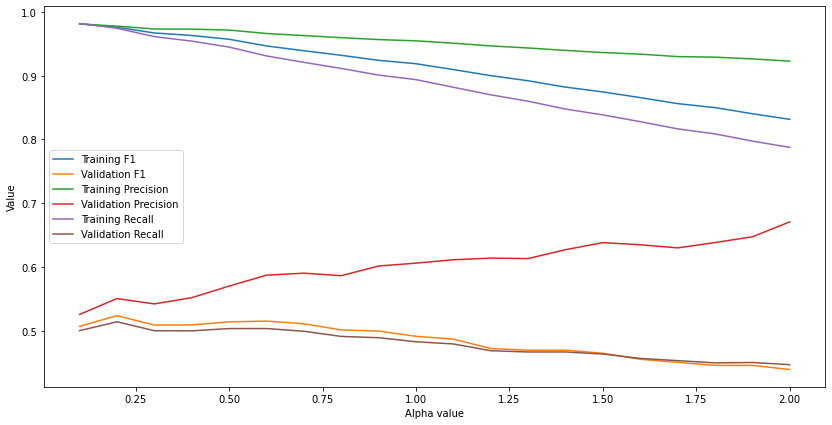

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14,7))
ax.plot(np.linspace(0.1, 2, 20), train_f1_mean, label='Training F1')
ax.plot(np.linspace(0.1, 2, 20), val_f1_mean, label='Validation F1')
ax.plot(np.linspace(0.1, 2, 20), train_prec_mean, label='Training Precision')
ax.plot(np.linspace(0.1, 2, 20), val_prec_mean, label='Validation Precision')
ax.plot(np.linspace(0.1, 2, 20), train_rec_mean, label='Training Recall')
ax.plot(np.linspace(0.1, 2, 20), val_rec_mean, label='Validation Recall')
ax.set_xlabel('Alpha value')
ax.set_ylabel('Value')
ax.legend(loc='best')

In [14]:
val_f1_mean

array([0.50718982, 0.52394105, 0.50922238, 0.50944667, 0.51427512,
       0.51545037, 0.5111836 , 0.50161407, 0.49975812, 0.49157197,
       0.48715014, 0.47243044, 0.46982698, 0.46987031, 0.46503522,
       0.45559782, 0.45085046, 0.44599454, 0.44606391, 0.43957667])

Optimum value for alpha = 0.3

In [15]:
train_acc = []
val_acc = []
train_prec = []
val_prec = []
train_rec = []
val_rec = []
train_f1 = []
val_f1 = []
confusion_matrices = []

for train_index, val_index in kf.split(train_documents, train_labels):

    Xtr, Xval = train_documents[train_index], train_documents[val_index]
    ytr, yval = train_labels[train_index], train_labels[val_index]

    vectorizer = CountVectorizer(tokenizer=Tokenizer(), preprocessor=Preprocessor())
    vectorizer.fit(Xtr)
    Xtr = vectorizer.transform(Xtr)
    Xval = vectorizer.transform(Xval)

    vocabulary = vectorizer.vocabulary_

    lex_pos_scores = np.zeros((1, len(vocabulary)))
    lex_neg_scores = np.zeros((1, len(vocabulary)))

    for j, term in enumerate(vocabulary):
        if term in analyser.lexicon and analyser.lexicon[term] > 0:
            lex_pos_scores[0, j] = 1
        elif term in analyser.lexicon and analyser.lexicon[term] < 0:
            lex_neg_scores[0, j] = 1

    lex_pos_train = np.sum(Xtr.multiply(lex_pos_scores), axis=1)
    lex_pos_val = np.sum(Xval.multiply(lex_pos_scores), axis=1)

    lex_neg_train = np.sum(Xtr.multiply(lex_neg_scores), axis=1)
    lex_neg_val = np.sum(Xval.multiply(lex_neg_scores), axis=1)

    Xtr = hstack((Xtr, lex_pos_train, lex_neg_train))
    Xval = hstack((Xval, lex_pos_val, lex_neg_val))

    classifier = MultinomialNB(alpha=0.3)
    classifier.fit(Xtr, ytr)

    pred_train = classifier.predict(Xtr)
    pred_val = classifier.predict(Xval)

    train_acc.append(accuracy_score(ytr, pred_train))
    val_acc.append(accuracy_score(yval, pred_val))
    train_prec.append(precision_score(ytr, pred_train, average='macro'))
    val_prec.append(precision_score(yval, pred_val, average='macro'))
    train_rec.append(recall_score(ytr, pred_train, average='macro'))
    val_rec.append(recall_score(yval, pred_val, average='macro'))
    train_f1.append(f1_score(ytr, pred_train, average='macro'))
    val_f1.append(f1_score(yval, pred_val, average='macro'))
    confusion_matrices.append(confusion_matrix(yval, pred_val))

train_acc_mean = np.mean(train_acc)
val_acc_mean = np.mean(val_acc)
train_prec_mean = np.mean(train_prec)
val_prec_mean = np.mean(val_prec)
train_rec_mean = np.mean(train_rec)
val_rec_mean = np.mean(val_rec)
train_f1_mean = np.mean(train_f1)
val_f1_mean = np.mean(val_f1)

C:\Users\Morg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Morg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Morg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Morg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Morg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarn

In [16]:
print(f'Train Accuracy = {train_acc_mean}, Test Accuracy = {val_acc_mean}')
print(f'Train Precision (macro average) = {train_prec_mean}, Test Precision (macro average) = {val_prec_mean}')
print(f'Train Recall (macro average) = {train_rec_mean}, Test Recall (macro average) = {val_rec_mean}')
print(f'Train F1 score (macro average) = {train_f1_mean}, Test F1 score (macro average) = {val_f1_mean}')
for cm in confusion_matrices:
    print(cm)

Train Accuracy = 0.9715631623779244, Test Accuracy = 0.6069701009331556
Train Precision (macro average) = 0.9731599627156523, Test Precision (macro average) = 0.5423479479222103
Train Recall (macro average) = 0.9612008361547257, Test Recall (macro average) = 0.5003537529965982
Train F1 score (macro average) = 0.966908048370455, Test F1 score (macro average) = 0.5092223787580306
[[18  5 27]
 [ 6  5 20]
 [ 9 10 78]]
[[25  1 24]
 [ 4 13 14]
 [10  6 81]]
[[22  5 22]
 [ 6  5 21]
 [12  6 79]]
[[23  8 18]
 [ 4 10 17]
 [11  8 78]]
[[18  3 29]
 [ 6  8 17]
 [13  7 76]]


### Results

In [17]:
vectorizer = CountVectorizer(tokenizer=Tokenizer(), preprocessor=Preprocessor())
vectorizer.fit(train_documents)
X_train = vectorizer.transform(train_documents)
X_test = vectorizer.transform(test_documents)
y_train = train_labels
y_test = test_labels

vocabulary = vectorizer.vocabulary_
    
lex_pos_scores = np.zeros((1, len(vocabulary)))
lex_neg_scores = np.zeros((1, len(vocabulary)))

for i, term in enumerate(vocabulary):
    if term in analyser.lexicon and analyser.lexicon[term] > 0:
        lex_pos_scores[0, i] = 1
    elif term in analyser.lexicon and analyser.lexicon[term] < 0:
        lex_neg_scores[0, i] = 1

lex_pos_train = np.sum(X_train.multiply(lex_pos_scores), axis=1)
lex_pos_test = np.sum(X_test.multiply(lex_pos_scores), axis=1)

lex_neg_train = np.sum(X_train.multiply(lex_neg_scores), axis=1)
lex_neg_test = np.sum(X_test.multiply(lex_neg_scores), axis=1)

X_train = hstack((X_train, lex_pos_train, lex_neg_train))
X_test = hstack((X_test, lex_pos_test, lex_neg_test))

classifier = MultinomialNB(alpha=0.3)
classifier.fit(X_train, y_train)

pred_train = classifier.predict(X_train)
pred_test = classifier.predict(X_test)

train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
train_prec = precision_score(y_train, pred_train, average='macro')
test_prec = precision_score(y_test, pred_test, average='macro')
train_rec = recall_score(y_train, pred_train, average='macro')
test_rec = recall_score(y_test, pred_test, average='macro')
train_f1 = f1_score(y_train, pred_train, average='macro')
test_f1 = f1_score(y_test, pred_test, average='macro')

print(f'Train Accuracy = {train_acc}, Test Accuracy = {test_acc}')
print(f'Train Precision (macro average) = {train_prec}, Test Precision (macro average) = {test_prec}')
print(f'Train Recall (macro average) = {train_rec}, Test Recall (macro average) = {test_rec}')
print(f'Train F1 score (macro average) = {train_f1}, Test F1 score (macro average) = {test_f1}')
print(classification_report(y_test, pred_test))

C:\Users\Morg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Train Accuracy = 0.9684684684684685, Test Accuracy = 0.6860986547085202
Train Precision (macro average) = 0.9676399068150667, Test Precision (macro average) = 0.6120643382012697
Train Recall (macro average) = 0.9573039781984063, Test Recall (macro average) = 0.5877593820481182
Train F1 score (macro average) = 0.9622840426119114, Test F1 score (macro average) = 0.5948717948717949
              precision    recall  f1-score   support

           0       0.69      0.65      0.67        62
           1       0.41      0.28      0.33        39
           2       0.74      0.84      0.78       122

    accuracy                           0.69       223
   macro avg       0.61      0.59      0.59       223
weighted avg       0.67      0.69      0.67       223



<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

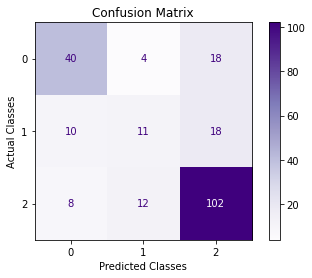

In [18]:
import pycm

cm = pycm.ConfusionMatrix(y_test, pred_test)
cm.plot(cmap=plt.cm.Purples, number_label=True, plot_lib="matplotlib")

In [19]:
error_indexes = pred_test != test_labels  # compare predictions to gold labels

# get the text of tweets where the classifier made an error:
docs_err = np.array(test_documents)[error_indexes]

# WRITE YOUR CODE HERE
pred_err = pred_test[error_indexes]
gold_err = np.array(test_labels)[error_indexes]

for i in range(20):  # just print the first ten
    print(f'Text: {docs_err[i]}; true label = {gold_err[i]}, prediction = {pred_err[i]}.')

Text: $AAPL bounce right now has no vol, more vol when it slid; true label = 1, prediction = 2.
Text: L&G completes UK's largest medically underwritten bulk pension risk deal; true label = 2, prediction = 0.
Text: RT @jan $ARNA Don't think buyout rumor strong enough too be driving this up just yet...when it is this may fly like aapl...// fly how high?; true label = 1, prediction = 2.
Text: Merkel's Government Said to Support Deutsche Boerse-LSE Merger; true label = 2, prediction = 1.
Text: London Stock Exchange seals Â£22 billion merger with Germany's Deutsche BÃ¶rse; true label = 2, prediction = 1.
Text: Whats up with $LULU?  Numbers looked good, not great, but good.  I think conference call will instill confidence.; true label = 1, prediction = 2.
Text: Sold out $TZA 45 $PUT (down $1), which were hedging my 45 $CALL. Letting the calls ride solo now.; true label = 2, prediction = 1.
Text: Facebook, near a buy point last week, faces a different technical test today https://t.co/c72LLMp

In [20]:
def show_top10(classifier, vectorizer):
    feature_names = vectorizer.vocabulary_
    for i, category in enumerate(classifier.classes_):
        top10 = classifier.feature_log_prob_[i,:].argsort()[::-1][0:20]
        print(f'Category {i} top words:')
        for j, idx in enumerate(top10):
            try:
                print(j+1, list(feature_names.keys())[list(feature_names.values()).index(idx)])
            except:
                if idx == 2757:
                    print(j+1, 'Positive Lexicon')
                else:
                    print(j+1, 'Negative Lexicon')
            
show_top10(classifier, vectorizer)

Category 0 top words:
1 ticker
2 Negative Lexicon
3 url
4 Negative Lexicon
5 short
6 low
7 's
8 price
9 share
10 sell
11 recall
12 hashtag
13 ...
14 i
15 x
16 fall
17 model
18 tesla
19 nosignpct
20 hit
Category 1 top words:
1 Negative Lexicon
2 ticker
3 Negative Lexicon
4 's
5 url
6 new
7 ceo
8 update
9 break
10 tesco
11 inbev
12 sale
13 sell
14 today
15 barclays
16 price
17 board
18 deal
19 group
20 i
Category 2 top words:
1 ticker
2 Negative Lexicon
3 Negative Lexicon
4 url
5 's
6 long
7 buy
8 high
9 ...
10 !
11 i
12 price
13 today
14 sale
15 share
16 nosignpct
17 break
18 astrazeneca
19 look
20 good


## Topic Modelling

### Pre-processing

In [21]:
import re
import nltk
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

lemmatizer = nltk.WordNetLemmatizer()

spec_char = ['(',')','-','[',']','{','}',';',':',',','.','/','?','@','#','$','%','^','&','*','_','~','!','..','...']

class Preprocessor(object):
    def __call__(self, headline):
        
        headline = re.sub(r'https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&\/=]*)', '', headline) # Remove URLs
        headline = re.sub(r'#[a-zA-Z1-9]*', '', headline) # Remove hashtags
        return headline
        
class Tokenizer(object):
    def __call__(self, text):
        
        result = []
        for token in simple_preprocess(text) :  # Tokenize
            if token not in STOPWORDS:
                token = lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(token, pos='a'), pos='v'), pos='n') # Lemmatize
                result.append(token)
        return result

In [22]:
tokenizer = Tokenizer()
preprocessor = Preprocessor()

for text in all_text:
    print(tokenizer.__call__(preprocessor.__call__(text)))

['royal', 'mail', 'chairman', 'donald', 'brydon', 'set', 'step']
['stake', 'high', 'astrazeneca', 'heart', 'drug', 'face', 'tough', 'competition']
['update', 'dairy', 'crest', 'lose', 'morrison', 'milk', 'contract']
['insight', 'hire', 'aviva', 'david', 'hillier', 'multi', 'asset', 'team']
['primark', 'rack', 'happy', 'christmas', 'strong', 'sale']
['update', 'pearson', 'expect', 'grow', 'year', 'solid', 'end']
['tesco', 'sell', 'blinkbox', 'broadband', 'service', 'talktalk']
['unilever', 'profit', 'rise', 'despite', 'sale', 'slump', 'china']
['tesco', 'lead', 'leap', 'ftse', 'mark', 'spencer', 'drop']
['royal', 'dutch', 'shell', 'profit', 'rise', 'dividend']
['morning', 'agenda', 'shire', 'deal', 'np']
['carnival', 'corporation', 'china', 'merchant', 'group', 'sign', 'memo', 'understand']
['teva', 'fda', 'approve', 'generic', 'version', 'astrazeneca', 'heartburn', 'drug']
['passenger', 'rise', 'easyjet', 'aer', 'lingus']
['tesco', 'abandon', 'video', 'stream', 'ambition', 'blinkbox', 

['amazon', 'attack', 'uk', 'grocery', 'market', 'morrison', 'deal']
['astrazeneca', 'share', 'price', 'acerta', 'deal', 'pay', 'orphan', 'drug', 'status']
['bhp', 'billiton', 'post', 'big', 'loss', 'slash', 'dividend']
['merge', 'lse', 'deutsche', 'bã', 'rse', 'lead', 'germany', 'kengeter']
['buy', 'jumbo', 'yielder', 'british', 'american', 'tobacco', 'plc', 'centrica', 'plc', 'john', 'wood', 'group', 'plc']
['trouble', 'brew', 'legal', 'general', 'group', 'plc', 'aviva', 'plc']
['bhp', 'billiton', 'drag', 'ftse', 'low', 'slash', 'dividend']
['bhp', 'billiton', 'slash', 'dividend', 'post', 'billion', 'net', 'loss']
['profit', 'hit', 'weak', 'energy', 'military', 'market']
['royal', 'mail', 'share', 'price', 'edge', 'low', 'group', 'raise', 'stamp', 'price']
['glaxosmithkline', 'start', 'hunt', 'successor', 'ceo', 'witty']
['rio', 'tinto', 'swing', 'loss', 'drop', 'dividend', 'policy']
['france', 'raise', 'concern', 'propose', 'lse', 'deutsche', 'boerse', 'deal']
['marketsbp', 'promote'

['yelp', 'wayyy', 'overvalue', 'right', 'imo', 'trade', 'single', 'digit', 'short', 'po', 'earn', 'near', 'term', 'target']
['renn', 'top', 'tail', 'min', 'chart', 'short']
['spy', 'weak', 'close']
['znga', 'look', 'test', 'resistance', 'point', 'cc', 'cfrazierjr', 'fletchtrade']
['efut', 'hod', 'post', 'buy', 'pm']
['aapl', 'short']
['soullor', 'regular', 'scrappy', 'swy', 'usually', 'present', 'sale', 'weak', 'margin', 'debt', 'way']
['aapl', 'take', 'short', 'punish', 'reminder', 'spear', 'strong', 'herd']
['think', 'fm', 'challendge', 'ema', 'distant', 'future', 'look', 'yesterday', 'volume']
['rt', 'dasan', 'tmtanalyst', 'aapl', 'master', 'supply', 'chain', 'corner', 'nand', 'apple', 'master', 'supply', 'chain']
['prlb', 'hang', 'tough', 'market', 'analyst', 'upgrade', 'week']
['amrn', 'accumulate', 'think', 'buy', 'hold', 'peace', 'today', 'tomorrow']
['axp', 'look', 'continuation', 'volume', 'increase']
['mt', 'theacsman', 'amaze', 'see', 'suddenly', 'tout', 'msft', 'long', 'fav

['iwm', 'relative', 'weakness', 'pretty', 'apparent', 'short', 'boat', 'get', 'prefer', 'boat', 'close']
['saltwaternurse', 'ino', 'test', 'day', 'time', 'profit', 'hedge', 'put']
['mat', 'big', 'trader', 'add', 'april', 'contract', 'day', 'ago']
['fti', 'breakout', 'today', 'report', 'earn', 'night']
['ko', 'miss', 'earn', 'expectation', 'quarter', 'today', 'strong', 'result', 'come', 'major', 'surprise']
['coh', 'gain', 'momentum', 'nice', 'buy', 'signal', 'long']
['baba', 'day', 'wks', 'month', 'watch', 'happen', 'fb', 'twtr', 'ipo', 'mrkt', 'need', 'washout', 'hunt', 'need', 'wait', 'stalk']
['rad', 'chart', 'flash', 'oversold']
['rsol', 'buy', 'share', 'today']
['aria', 'reason', 'short', 'long', 'steady', 'small', 'climb', 'best', 'way', 'accrue', 'value', 'imo']
['camt', 'look', 'like', 'break']
['athn', 'like', 'good', 'short', 'setup', 'stop', 'day', 'position']
['kior', 'god', 'market', 'get', 'crush', 'today', 'gotta', 'hold', 'recover', 'tomorrow', 'imagine']
['aapl', 'down

['tesla', 'motor', 'recall', 'model', 'suv', 'tsla']
['siriusxm', 'add', 'net', 'new', 'subscriber', 'quarter', 'siri']
['star', 'analyst', 'brianwieser', 'pivotal', 'research', 'upgrade', 'rat', 'googl', 'buy', 'brian', 'success', 'rate']
['long', 'endp', 'agn', 'rumor']
['know', 'seat', 'sit', 'tsla', 'tesla', 'recall', 'model', 'car']
['bbby', 'stock', 'option', 'trade', 'double', 'money', 'thestreet']
['mark', 'recall', 'tesla', 'recall', 'faulty', 'rd', 'row', 'seat', 'tsla']
['stx', 'bear', 'market', 'emc', 'sndk', 'wdc']
['vrtx', 'early', 'technical', 'buy', 'signal', 'confirmation', 'need', 'fundam', 'incentive']
['fb', 'start', 'relative', 'strength', 'sign', 'potential', 'daily']
['cgrantwsj', 'think', 'tsla', 'bubble', 'time', 'long', 'ppl', 'love', 'car', 'get', 'fund']
['sbux', 'head', 'dma', 'certain', 'doom', 'hold']
['amzn', 'long', 'earn', 'look', 'good']
['googl', 'short', 'upper', 'bb', 'overbought']
['timberrrr', 'tsla']
['heat', 'yahoo', 'yhoo', 'wall', 'street', '

In [23]:
preprocessor = Preprocessor()
tokenizer = Tokenizer()

all_text_negative = all_text[all_labels == 0]
all_text_positive = all_text[all_labels == 2]

texts = [all_text_negative, all_text_positive]
processed_texts = [[], []]

for i, docs in enumerate(texts):
    for text in docs:
        text = tokenizer.__call__(preprocessor.__call__(text))
        processed_texts[i].append(text)

In [24]:
from gensim.corpora import Dictionary

dictionaries = []

for texts in processed_texts:
    dictionaries.append(Dictionary(texts))

bow_corpus_negative = [dictionaries[0].doc2bow(doc) for doc in processed_texts[0]]
bow_corpus_positive = [dictionaries[1].doc2bow(doc) for doc in processed_texts[1]]

In [25]:
from gensim.models import TfidfModel

tfidf_model_neg = TfidfModel(bow_corpus_negative)
tfidf_model_pos = TfidfModel(bow_corpus_positive)

In [26]:
bow_corpus_negative_idf = []
bow_corpus_positive_idf = []
for text in bow_corpus_negative:
    bow_corpus_negative_idf.append(tfidf_model_neg[text])
for text in bow_corpus_positive:
    bow_corpus_positive_idf.append(tfidf_model_pos[text])

### LDA

In [27]:
from gensim.models import LdaModel

lda_model_negative =  LdaModel(bow_corpus_negative_idf, 
                      num_topics=5, 
                      id2word=dictionaries[0],                                    
                      passes=10,
                    ) 

lda_model_positive =  LdaModel(bow_corpus_positive_idf, 
                      num_topics=5, 
                      id2word=dictionaries[1],                                    
                      passes=10,
                    )

In [28]:
for model in [lda_model_negative, lda_model_positive]:

    for idx, topic in model.print_topics(-1):
        print("Topic: {} \nWords: {}".format(idx, topic ))
        print("\n")

Topic: 0 
Words: 0.018*"recall" + 0.016*"tsla" + 0.015*"model" + 0.012*"tesla" + 0.008*"suv" + 0.007*"sell" + 0.007*"sbux" + 0.006*"seat" + 0.006*"motor" + 0.005*"car"


Topic: 1 
Words: 0.005*"time" + 0.005*"lead" + 0.004*"ftse" + 0.004*"hit" + 0.004*"tsla" + 0.004*"market" + 0.003*"loss" + 0.003*"new" + 0.003*"cut" + 0.003*"glaxosmithkline"


Topic: 2 
Words: 0.005*"bank" + 0.005*"share" + 0.004*"gain" + 0.004*"tesco" + 0.004*"price" + 0.004*"continue" + 0.004*"like" + 0.004*"face" + 0.004*"fb" + 0.004*"sale"


Topic: 3 
Words: 0.008*"short" + 0.007*"spy" + 0.006*"aapl" + 0.006*"low" + 0.005*"look" + 0.005*"fb" + 0.004*"lol" + 0.004*"fall" + 0.004*"weak" + 0.004*"get"


Topic: 4 
Words: 0.005*"short" + 0.005*"drop" + 0.005*"price" + 0.005*"year" + 0.004*"slide" + 0.004*"week" + 0.004*"big" + 0.004*"strategy" + 0.004*"fall" + 0.004*"tumble"


Topic: 0 
Words: 0.007*"amzn" + 0.005*"share" + 0.004*"price" + 0.004*"break" + 0.004*"look" + 0.004*"hod" + 0.004*"call" + 0.004*"dividend" + 0

### HDP Model

In [29]:
from gensim.models import HdpModel

hdp_model_negative = HdpModel(bow_corpus_negative_idf, 
                     id2word=dictionaries[0],
                     alpha=1,
                     gamma=1, T=20)

hdp_model_positive = HdpModel(bow_corpus_positive_idf, 
                     id2word=dictionaries[1],
                     alpha=1,
                     gamma=1, T=20)

for idx, topic in hdp_model_negative.print_topics(20):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")
   
for idx, topic in hdp_model_positive.print_topics(20):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")    

Topic: 0 
Words: 0.006*triangle + 0.006*lloyd + 0.006*mood + 0.005*pride + 0.005*significant + 0.005*ftc + 0.005*ex + 0.005*skid + 0.005*ofix + 0.004*doom


Topic: 1 
Words: 0.007*uso + 0.006*breakout + 0.006*metal + 0.006*possible + 0.005*blue + 0.005*show + 0.005*unit + 0.005*issue + 0.004*program + 0.004*bailout


Topic: 2 
Words: 0.007*year + 0.006*tip + 0.005*global + 0.005*mark + 0.005*cat + 0.005*decent + 0.005*ship + 0.005*qqq + 0.005*emc + 0.004*matthey


Topic: 3 
Words: 0.009*oil + 0.007*meltdown + 0.006*handle + 0.005*axp + 0.005*retreat + 0.005*week + 0.005*invalidate + 0.005*stamp + 0.004*legal + 0.004*unture


Topic: 4 
Words: 0.006*sale + 0.006*divest + 0.006*decent + 0.005*toxic + 0.005*resistance + 0.005*qcom + 0.005*threat + 0.005*copyright + 0.004*weakness + 0.004*gakrum


Topic: 5 
Words: 0.008*toll + 0.005*chart + 0.005*copper + 0.005*sad + 0.005*imho + 0.005*bhp + 0.004*retracement + 0.004*grocer + 0.004*trend + 0.004*breach


Topic: 6 
Words: 0.006*note + 0.005*

In [30]:
def plot_global_topic_weights(hdp_model):
    global_topic_weights = hdp_model.m_varphi_ss / np.sum(hdp_model.m_varphi_ss)

    plt.bar(np.arange(len(global_topic_weights)), global_topic_weights, color='#3F007D')
    plt.ylabel('Probability')
    plt.xlabel('Topic ID')

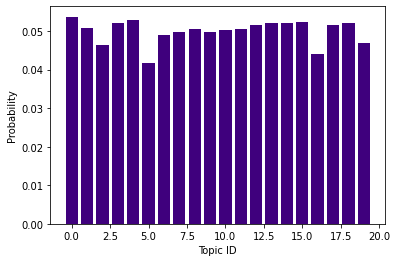

In [31]:
plot_global_topic_weights(hdp_model_negative)

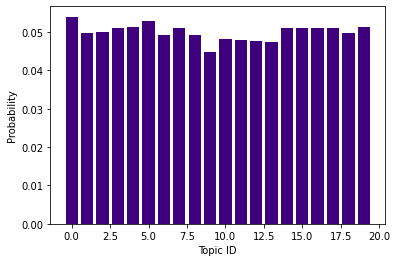

In [32]:
plot_global_topic_weights(hdp_model_positive)

# Task 2

## Named Entity Recognition

# BIONLP 2004

This dataset contains abstracts from MEDLINE, a database containing journal articles from fields including medicine and pharmacy. 
The data was collected by searching for the terms ‘human’, ‘blood cells’ and ‘transcription factors’, and then annotated with five entity types: DNA, protein, cell type, cell line, RNA. 

More information in the paper: https://aclanthology.org/W04-1213.pdf

The data can be downloaded from HuggingFace: https://huggingface.co/datasets/tner/bionlp2004

In [33]:
dataset = load_dataset(
    "tner/bionlp2004", 
    cache_dir='./data_cache'
)

print(f'The dataset is a dictionary with {len(dataset)} splits: \n\n{dataset}')

Found cached dataset bionlp2004 (C:/Users/Morg/OneDrive/Documents/MSc/TB2/intro_data_analytics/Coursework/data_cache/tner___bionlp2004/bionlp2004/1.0.0/9f41d3f0270b773c2762dee333ae36c29331e2216114a57081f77639fdb5e904)
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.82it/s]

The dataset is a dictionary with 3 splits: 

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 16619
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 1927
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 3856
    })
})


The dataset is already split into train, validation and test. It may be useful to reformat the DatasetDict object into lists of sentences and tags:

In [34]:
train_sentences_ner = [item['tokens'] for item in dataset['train']]
train_labels_ner = [[str(tag) for tag in item['tags']] for item in dataset['train']]

val_sentences_ner = [item['tokens'] for item in dataset['validation']]
val_labels_ner = [[str(tag) for tag in item['tags']] for item in dataset['validation']]

test_sentences_ner = [item['tokens'] for item in dataset['test']]
test_labels_ner = [[str(tag) for tag in item['tags']] for item in dataset['test']]

In [35]:
print(f'Number of training sentences = {len(train_sentences_ner)}')
print(f'Number of validation sentences = {len(val_sentences_ner)}')
print(f'Number of test sentences = {len(test_sentences_ner)}')

Number of training sentences = 16619
Number of validation sentences = 1927
Number of test sentences = 3856


In [36]:
print(f'What does one instance look like from the training set? \n\n{train_sentences_ner[234]}')
print(f'...and here is its corresponding label \n\n{train_labels_ner[234]}')

What does one instance look like from the training set? 

['Hence', ',', 'PPAR', 'can', 'positively', 'or', 'negatively', 'influence', 'TH', 'action', 'depending', 'on', 'TRE', 'structure', 'and', 'THR', 'isotype', '.']
...and here is its corresponding label 

['0', '0', '3', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '3', '4', '0']


In [37]:
print(f'Number of unique labels: {np.unique(np.concatenate(train_labels_ner))}')

Number of unique labels: ['0' '1' '10' '2' '3' '4' '5' '6' '7' '8' '9']


These are the tags used to annotate the entities:

In [38]:
# mapping from labels to the tags

id2label = {
    "O": 0,
    "B-DNA": 1,
    "I-DNA": 2,
    "B-protein": 3,
    "I-protein": 4,
    "B-cell_type": 5,
    "I-cell_type": 6,
    "B-cell_line": 7,
    "I-cell_line": 8,
    "B-RNA": 9,
    "I-RNA": 10
}

label2id = {v:k for k, v in id2label.items()}
print(label2id)

{0: 'O', 1: 'B-DNA', 2: 'I-DNA', 3: 'B-protein', 4: 'I-protein', 5: 'B-cell_type', 6: 'I-cell_type', 7: 'B-cell_line', 8: 'I-cell_line', 9: 'B-RNA', 10: 'I-RNA'}


In [39]:
label2id[0]

'O'

# Named Entity Recognition

In [40]:
train_sentences_crf = [[] for _ in train_sentences_ner]
val_sentences_crf = [[] for _ in val_sentences_ner]
test_sentences_crf = [[] for _ in test_sentences_ner]

for i, sentence in enumerate(train_sentences_ner):
    for j, token in enumerate(sentence):
         train_sentences_crf[i].append((token, label2id[int(train_labels_ner[i][j])]))
            
for i, sentence in enumerate(val_sentences_ner):
    for j, token in enumerate(sentence):
         val_sentences_crf[i].append((token, label2id[int(val_labels_ner[i][j])]))
            
for i, sentence in enumerate(test_sentences_ner):
    for j, token in enumerate(sentence):
         test_sentences_crf[i].append((token, label2id[int(test_labels_ner[i][j])]))

In [41]:
for label in list(id2label.keys())[1:]:
    print('\n\n' + label)
    for sentence in train_sentences_crf[0:200]:
        for token in sentence:
            if token[1] == label:
                print(token[0])



B-DNA
immunoglobulin
immunoglobulin
enhancer
E
E
IgH
enhancer
cellular
Ig
human
LTR
c-myb
recombinant
NM23.H1
NM23
metastasis-suppressor
NM23.H1
NM23
NM23
genomic
interleukin
IL-6
LPS-inducible
DNA
-158
-153
nuclear
IL-6
NF-IL6
bacterial
CD14
tissue-specific
CD14
bp
binding
Sp1-binding
Sp1-binding
t
consensus
HLF
HLF
reporter
HLF
reporter
nonoptimal
myeloperoxidase
tissue
kappa
kappa
5'-CGGAGTTTCC-3
5'-flanking
human
TF
TF
TF
TF
TF
heterologous
kappa
proto-oncogene
proto-oncogene
kappa
IL-2R
HIV-1-LTR
LTR
cAMP
CRE


I-DNA
heavy-chain
enhancer
heavy-chain
(
IgH
)
enhancer
box
box
enhancer
and
viral
genes
kappa
enhancer
immunodeficiency
virus
(
HIV
)
long
terminal
repeat
gene
plasmid
gene
gene
gene
gene
gene
gene
DNA
6
gene
gene
IL-6
promoter
fragment
to
-49
to
-145
factor
NF-kappa
B
(
positions
-72
to
-63
)
motifs
promoter
and
NF-kappa
B
sites
or
mycobacterial
response
elements
5
'
upstream
sequence
promoter
5
'
upstream
sequence
-128
to
-70
sites
site
site
(
17
;
19
)
sequence
consen

In [42]:
import re, unicodedata

class CustomCRFTagger(nltk.tag.CRFTagger):
    _current_tokens = None
    
    def _get_features(self, tokens, idx):
            """
            Extract basic features about this word including
                - Current word
                - is it capitalized?
                - Does it have punctuation?
                - Does it have a number?
                - Suffixes up to length 3

            Note that : we might include feature over previous word, next word etc.

            :return: a list which contains the features
            :rtype: list(str)
            """
            token = tokens[idx]

            feature_list = []

            if not token:
                return feature_list

            # Capitalization
            if token[0].isupper():
                feature_list.append("CAP_FIRST")

            # Number
            if re.search(self._pattern, token) is not None:
                feature_list.append("HAS_NUM")

            # Punctuation
            punc_cat = {"Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"}
            if all(unicodedata.category(x) in punc_cat for x in token):
                feature_list.append("PUNCTUATION")

            # Suffix up to length 3
            if len(token) > 1:
                feature_list.append("SUF_" + token[-1:])
            if len(token) > 2:
                feature_list.append("SUF_" + token[-2:])
            if len(token) > 3:
                feature_list.append("SUF_" + token[-3:])

            # Current word
            feature_list.append("WORD_" + token)
            
            # Next word and previous word
            if idx > 0:
                feature_list.append("PREVWORD_" + tokens[idx-1])
            if idx < len(tokens)-1:
                feature_list.append("NEXTWORD_" + tokens[idx+1])
            
            # Hypen
            if '-' in token:
                feature_list.append('HYPHEN')
            
            # All caps or 2+ caps
            caps = 0
            if len(token) > 1:
                for letter in token:
                    if letter.isupper():
                        caps += 1
                if caps == len(token):
                    feature_list.append('ALL_CAPS')
                elif caps > 1:
                    feature_list.append('2+_CAPS')
            
            # Word shape
            word_shape = ""
            for letter in token:
                if re.match(f'[0-9]', letter):
                    word_shape += 'd'
                if re.match(f'[a-z]', letter):
                    word_shape += 'x'
                if re.match(f'[A-Z]', letter):
                    word_shape += 'X'
                else:
                    word_shape += letter
            feature_list.append(word_shape)
            
            # POS tags
            feature_list.append(nltk.pos_tag(tokens)[idx][1])

            return feature_list

In [43]:
def train_CRF_NER_tagger(train_set):
    tagger = CustomCRFTagger()
    tagger.train(train_set, 'model.crf.tagger')
    return tagger

tagger = train_CRF_NER_tagger(train_sentences_crf)

In [44]:
def extract_spans(tagged_sents):
    """
    Extract a list of tagged spans for each named entity type, 
    where each span is represented by a tuple containing the 
    start token and end token indexes.
    
    returns: a dictionary containing a list of spans for each entity type.
    """
    spans = {}
        
    for sidx, sent in enumerate(tagged_sents):
        start = -1
        entity_type = None
        for i, (tok, lab) in enumerate(sent):
            if 'B-' in lab:
                start = i
                end = i + 1
                entity_type = lab[2:]
            elif 'I-' in lab:
                end = i + 1
            elif lab == 'O' and start >= 0:
                
                if entity_type not in spans:
                    spans[entity_type] = []
                
                spans[entity_type].append((start, end, sidx))
                start = -1      
        # Sometimes an I-token is the last token in the sentence, so we still have to add the span to the list
        if start >= 0:    
            if entity_type not in spans:
                spans[entity_type] = []
                
            spans[entity_type].append((start, end, sidx))
                
    return spans


def cal_span_level_f1(test_sents, test_sents_with_pred):
    # get a list of spans from the test set labels
    gold_spans = extract_spans(test_sents)

    # get a list of spans predicted by our tagger
    pred_spans = extract_spans(test_sents_with_pred)
    
    # compute the metrics for each class:
    prec_per_class = []
    rec_per_class = []
    f1_per_class = []
    
    ne_types = gold_spans.keys()  # get the list of named entity types (not the tags)
    
    for ne_type in ne_types:
        # compute the confusion matrix
        true_pos = 0
        false_pos = 0
        
        for span in pred_spans[ne_type]:
            if span in gold_spans[ne_type]:
                true_pos += 1
            else:
                false_pos += 1
                
        false_neg = 0
        for span in gold_spans[ne_type]:
            if span not in pred_spans[ne_type]:
                false_neg += 1
                
        if true_pos + false_pos == 0:
            precision = 0
        else:
            precision = true_pos / float(true_pos + false_pos)
        print(f'Precision score for class {ne_type} = {precision}')
        prec_per_class.append(precision)
            
        if true_pos + false_neg == 0:
            recall = 0
        else:
            recall = true_pos / float(true_pos + false_neg)
        print(f'Recall score for class {ne_type} = {recall}')
        rec_per_class.append(recall)
              
        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * precision * recall / (precision + recall)
            
        f1_per_class.append(f1)
        print(f'F1 score for class {ne_type} = {f1}')
        
    print(f'Macro-average Precision score = {np.mean(prec_per_class)}')
    print(f'Macro-average Recall score = {np.mean(rec_per_class)}')
    print(f'Macro-average f1 score = {np.mean(f1_per_class)}')

In [45]:
predicted_tags = tagger.tag_sents(test_sentences_ner)

In [46]:
cal_span_level_f1(test_sentences_crf, predicted_tags)

Precision score for class protein = 0.6617965367965368
Recall score for class protein = 0.7346816179415299
F1 score for class protein = 0.6963370658568989
Precision score for class cell_type = 0.7900912646675359
Recall score for class cell_type = 0.6338912133891214
F1 score for class cell_type = 0.7034242600116076
Precision score for class DNA = 0.6697435897435897
Recall score for class DNA = 0.621904761904762
F1 score for class DNA = 0.6449382716049383
Precision score for class cell_line = 0.5233463035019456
Recall score for class cell_line = 0.5456389452332657
F1 score for class cell_line = 0.5342601787487588
Precision score for class RNA = 0.6293103448275862
Recall score for class RNA = 0.6186440677966102
F1 score for class RNA = 0.6239316239316239
Macro-average Precision score = 0.6548576079074389
Macro-average Recall score = 0.6309521212530579
Macro-average f1 score = 0.6405782800307656


Cell-line predictions seem to be worse than the other named entities.

In [58]:
cell_line_gold = []
cell_line_pred = []

for i, sentence in enumerate(test_sentences_crf):
    for j, word in enumerate(sentence):
        if 'cell_line' in word[1]:
            cell_line_gold.append(sentence)
            cell_line_pred.append(predicted_tags[i])
            break

In [59]:
cell_line_gold

[[('Octamer-binding', 'B-protein'),
  ('proteins', 'I-protein'),
  ('from', 'O'),
  ('B', 'B-cell_line'),
  ('or', 'I-cell_line'),
  ('HeLa', 'I-cell_line'),
  ('cells', 'I-cell_line'),
  ('stimulate', 'O'),
  ('transcription', 'O'),
  ('of', 'O'),
  ('the', 'O'),
  ('immunoglobulin', 'B-DNA'),
  ('heavy-chain', 'I-DNA'),
  ('promoter', 'I-DNA'),
  ('in', 'O'),
  ('vitro', 'O'),
  ('.', 'O')],
 [('Extracts', 'O'),
  ('of', 'O'),
  ('the', 'O'),
  ('B-cell', 'B-cell_line'),
  ('line', 'I-cell_line'),
  (',', 'O'),
  ('BJA-B', 'B-cell_line'),
  (',', 'O'),
  ('contain', 'O'),
  ('high', 'O'),
  ('levels', 'O'),
  ('of', 'O'),
  ('NF-A2', 'B-protein'),
  ('and', 'O'),
  ('specifically', 'O'),
  ('transcribe', 'O'),
  ('Ig', 'B-DNA'),
  ('promoters', 'I-DNA'),
  ('.', 'O')],
 [('In', 'O'),
  ('contrast', 'O'),
  (',', 'O'),
  ('extracts', 'O'),
  ('from', 'O'),
  ('HeLa', 'B-cell_line'),
  ('cells', 'I-cell_line'),
  ('transcribed', 'O'),
  ('the', 'O'),
  ('Ig', 'B-DNA'),
  ('promoter', '

In [60]:
cell_line_pred

[[('Octamer-binding', 'B-protein'),
  ('proteins', 'I-protein'),
  ('from', 'O'),
  ('B', 'O'),
  ('or', 'O'),
  ('HeLa', 'B-cell_line'),
  ('cells', 'I-cell_line'),
  ('stimulate', 'O'),
  ('transcription', 'O'),
  ('of', 'O'),
  ('the', 'O'),
  ('immunoglobulin', 'B-DNA'),
  ('heavy-chain', 'I-DNA'),
  ('promoter', 'I-DNA'),
  ('in', 'O'),
  ('vitro', 'O'),
  ('.', 'O')],
 [('Extracts', 'O'),
  ('of', 'O'),
  ('the', 'O'),
  ('B-cell', 'B-cell_line'),
  ('line', 'I-cell_line'),
  (',', 'O'),
  ('BJA-B', 'B-protein'),
  (',', 'O'),
  ('contain', 'O'),
  ('high', 'O'),
  ('levels', 'O'),
  ('of', 'O'),
  ('NF-A2', 'B-DNA'),
  ('and', 'I-DNA'),
  ('specifically', 'I-DNA'),
  ('transcribe', 'I-DNA'),
  ('Ig', 'I-DNA'),
  ('promoters', 'I-DNA'),
  ('.', 'O')],
 [('In', 'O'),
  ('contrast', 'O'),
  (',', 'O'),
  ('extracts', 'O'),
  ('from', 'O'),
  ('HeLa', 'B-cell_line'),
  ('cells', 'I-cell_line'),
  ('transcribed', 'O'),
  ('the', 'O'),
  ('Ig', 'B-DNA'),
  ('promoter', 'I-DNA'),
  ('p

In [47]:
predicted_tags_val = tagger.tag_sents(val_sentences_ner)

In [49]:
cal_span_level_f1(val_sentences_crf, predicted_tags_val)

Precision score for class DNA = 0.7324902723735408
Recall score for class DNA = 0.6028823058446757
F1 score for class DNA = 0.6613965744400527
Precision score for class protein = 0.7747048903878584
Recall score for class protein = 0.774966261808367
F1 score for class protein = 0.7748355540563333
Precision score for class cell_type = 0.7575250836120402
Recall score for class cell_type = 0.7294685990338164
F1 score for class cell_type = 0.7432321575061526
Precision score for class cell_line = 0.73989898989899
Recall score for class cell_line = 0.5943204868154158
F1 score for class cell_line = 0.6591676040494938
Precision score for class RNA = 0.7207207207207207
Recall score for class RNA = 0.6106870229007634
F1 score for class RNA = 0.6611570247933886
Macro-average Precision score = 0.7450679913986301
Macro-average Recall score = 0.6624649352806077
Macro-average f1 score = 0.6999577829690842
